Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_smoothed_ctr, get_linearized_likes, ab_test_report

In [2]:
connection = {'host': 'http://172.18.0.1:8123', 'database': 'test'}

In [4]:
query = "select value from {db}.ctl_metadata where table='test.feed_actions' and param='timedelta'"
days_shift = int(ph.read_clickhouse(query, connection=connection).min().to_list()[0])

period_old = ['2022-10-03', '2022-10-09']
period_new = [(dt.strptime(d, '%Y-%m-%d')+td(days=days_shift)).strftime('%Y-%m-%d') for d in period_old]

In [5]:
query = '''
    select 
        exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from test.feed_actions 
    where exp_group in (0, 1, 2, 3) and toDate(time) between '{}' and '{}'
    group by exp_group, user_id
'''.format(*period_new)

feed_actions_ctr_df = ph.read_clickhouse(query, connection=connection)
feed_actions_ctr_df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,116668,4,36,0.111111
1,0,32784,5,43,0.116279
2,3,505,9,24,0.375000
3,0,114807,2,18,0.111111
4,0,5143,14,62,0.225806


In [6]:
feed_actions_ctr_df.groupby('exp_group', as_index = False).agg({'user_id': 'count'})

,exp_group,user_id
0,0,9999
1,1,10079
2,2,9952
3,3,10049


In [7]:
# Get global CTRs
global_ctr_a1 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==0]['likes'].sum() / \
                feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==0]['views'].sum()
global_ctr_a2 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==1]['likes'].sum() / \
                feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==1]['views'].sum()
global_ctr_b1 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==3]['likes'].sum() / \
                feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==3]['views'].sum()
global_ctr_b2 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==2]['likes'].sum() / \
                feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==2]['views'].sum()

In [8]:
# Get smoothed CTRs
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==0, 'smoothed_ctr'] = \
    feed_actions_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_a1, 5), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==1, 'smoothed_ctr'] = \
    feed_actions_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_a2, 5), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==2, 'smoothed_ctr'] = \
    feed_actions_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_b2, 5), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==3, 'smoothed_ctr'] = \
    feed_actions_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_b1, 5), axis=1)

In [9]:
# Get linearized likes
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==0, 'linearized_likes'] = \
    feed_actions_ctr_df.apply(lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_a1), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==1, 'linearized_likes'] = \
    feed_actions_ctr_df.apply(lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_a2), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==2, 'linearized_likes'] = \
    feed_actions_ctr_df.apply(lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_a2), axis=1)
feed_actions_ctr_df.loc[feed_actions_ctr_df['exp_group']==3, 'linearized_likes'] = \
    feed_actions_ctr_df.apply(lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_a1), axis=1)

## Comparison of 0 and 3 groups

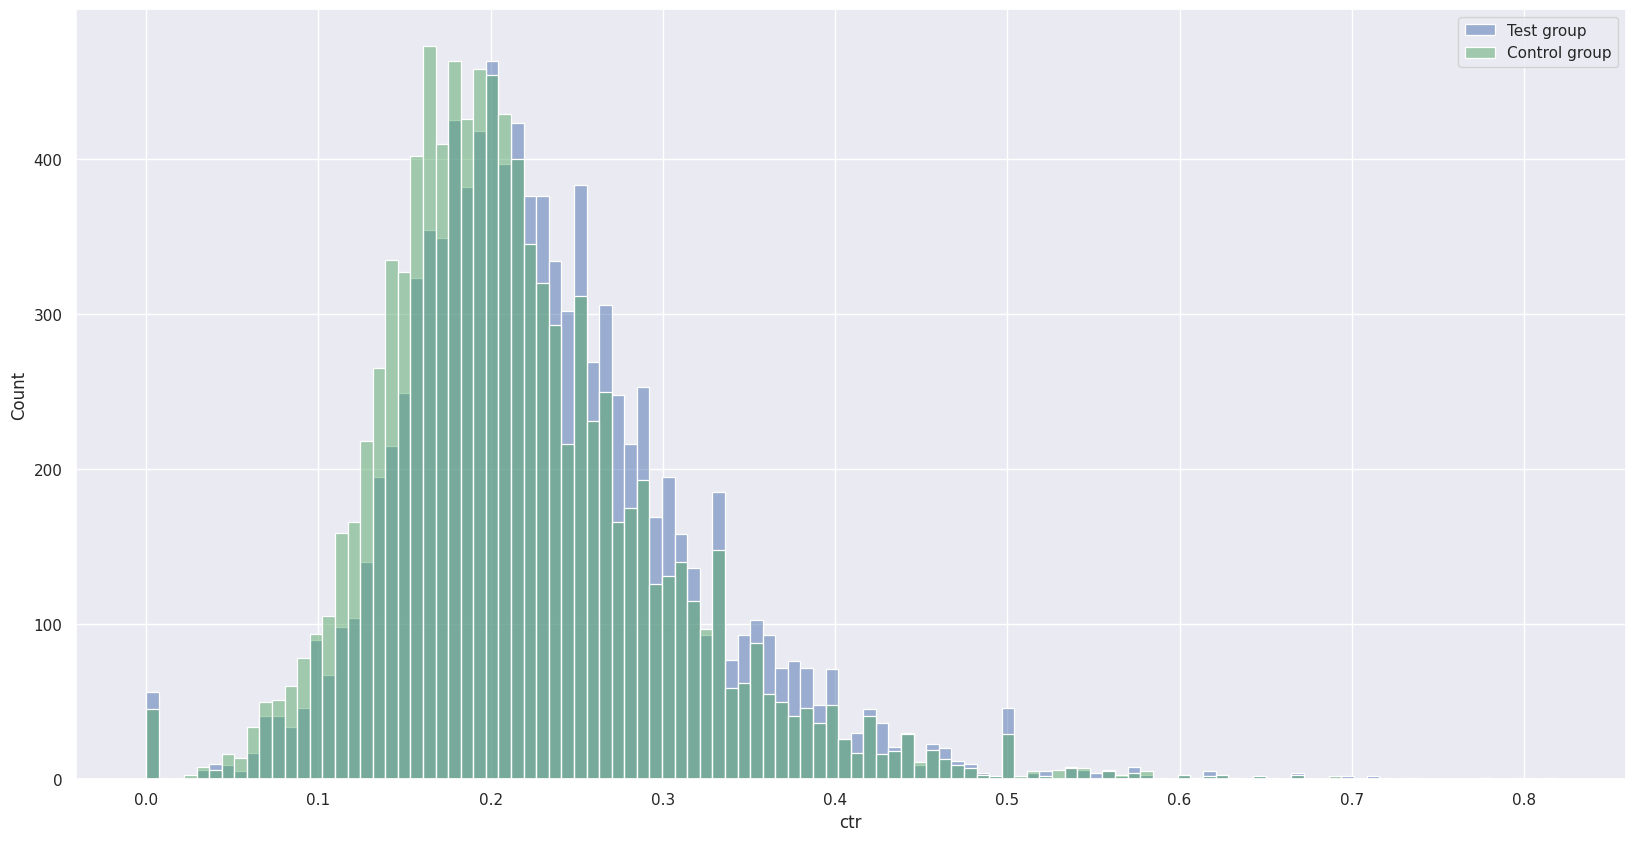

In [10]:
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_ctr_df[feed_actions_ctr_df['exp_group'].isin([0, 3])], x='ctr', hue='exp_group', 
             palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

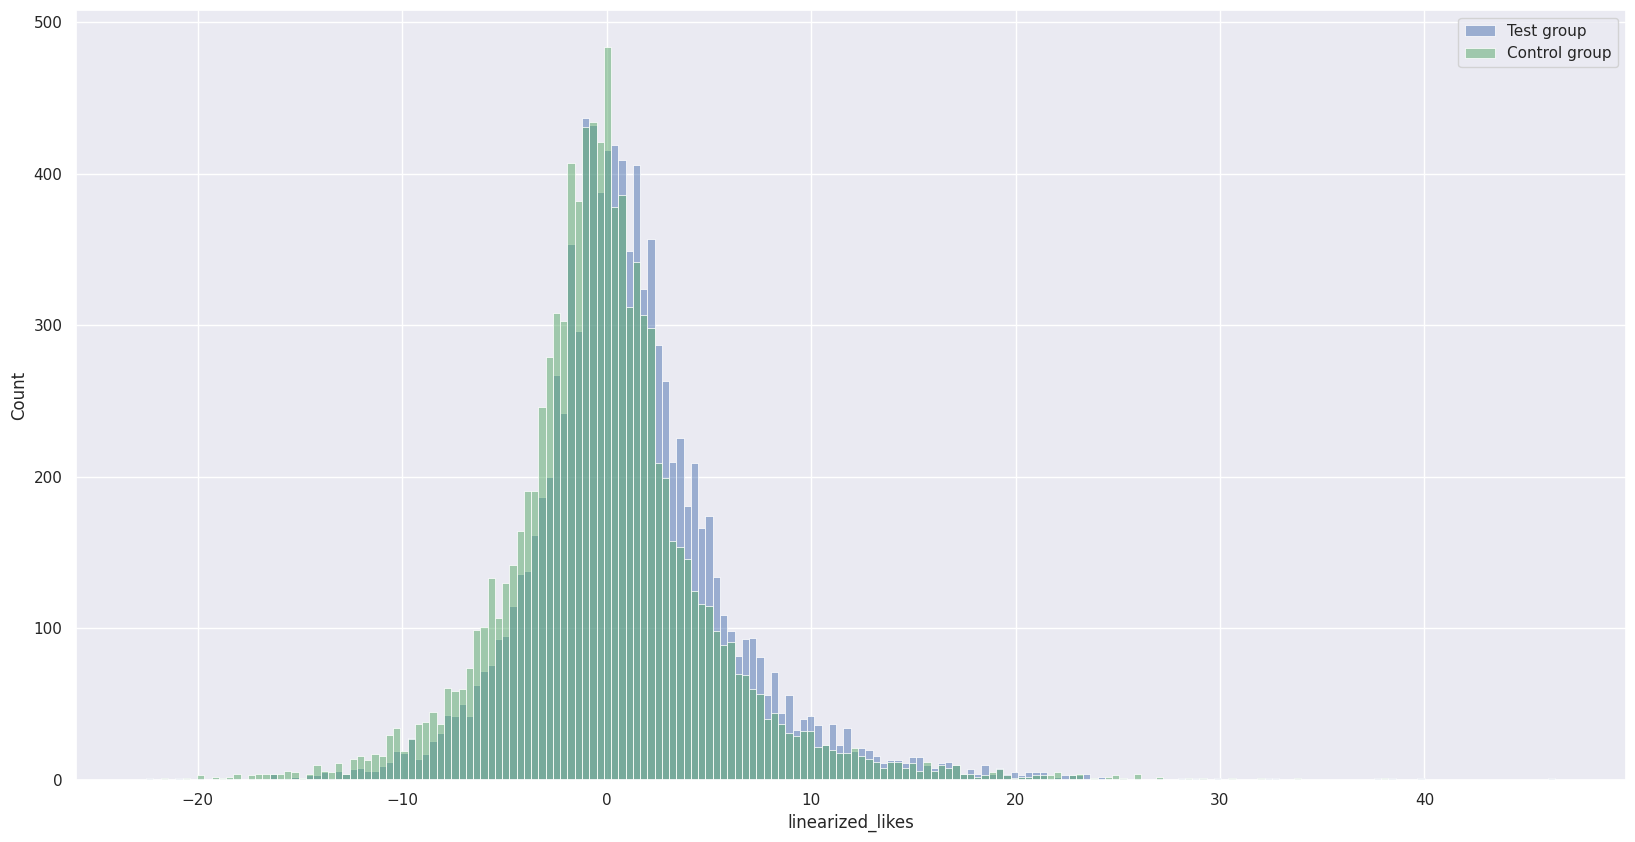

In [11]:
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_ctr_df[feed_actions_ctr_df['exp_group'].isin([0, 3])], x='linearized_likes', hue='exp_group', 
             palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

In [12]:
ab_test_report(feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==0],
               feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==3],
               metrics=['ctr', 'smoothed_ctr', 'linearized_likes'],
               tests=['ttest']
              )

,ctr,smoothed_ctr,linearized_likes
,ttest,ttest,ttest
statistic,-1.390080e+01,-1.634566e+01,-1.522068e+01
pvalue,9.995990e-44,1.136413e-59,5.038379e-52


## Comparison of 1 and 2 groups

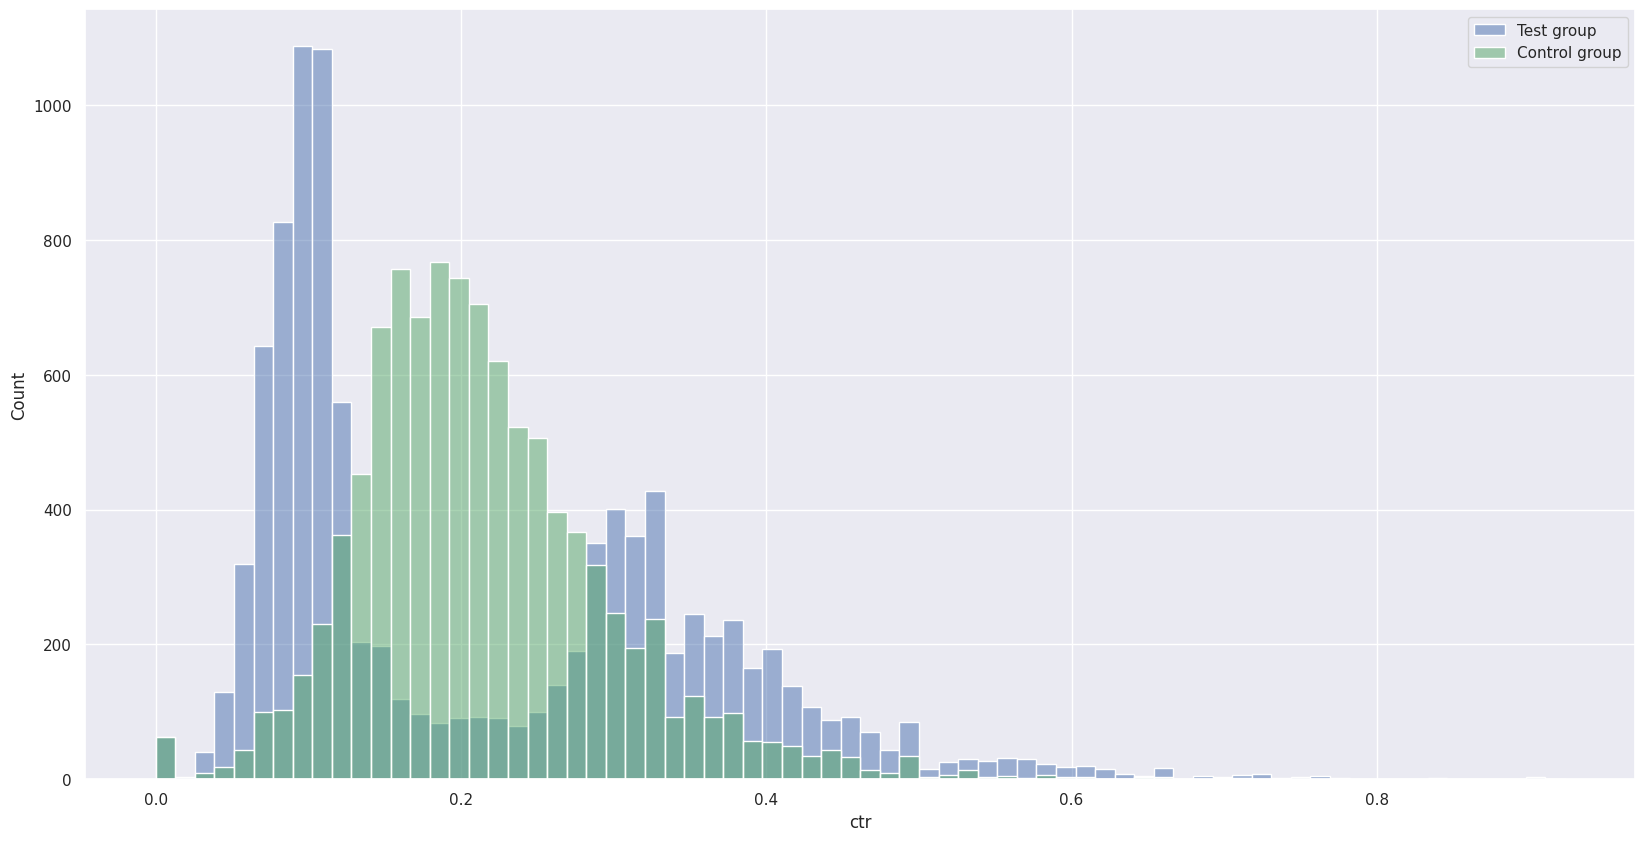

In [13]:
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_ctr_df[feed_actions_ctr_df['exp_group'].isin([1, 2])], x='ctr', hue='exp_group', 
             palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

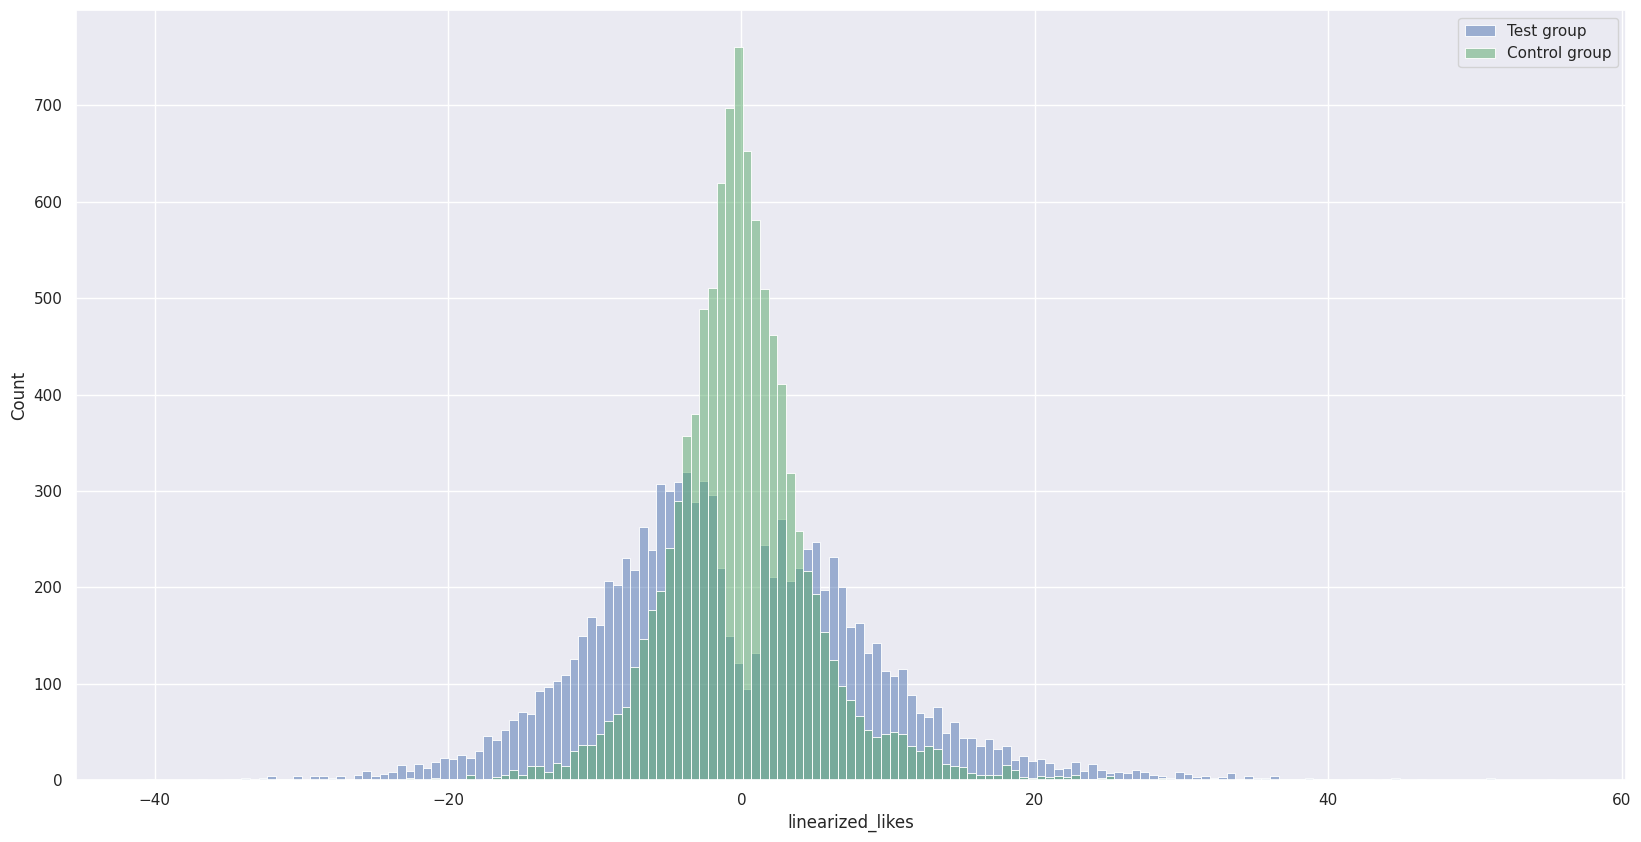

In [14]:
sns.set(rc={'figure.figsize':(20, 10)}) 
sns.histplot(data=feed_actions_ctr_df[feed_actions_ctr_df['exp_group'].isin([1, 2])], x='linearized_likes', hue='exp_group', 
             palette=['g', 'b'])
_ = plt.legend(labels=['Test group', 'Control group'])

In [15]:
ab_test_report(feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==1],
               feed_actions_ctr_df[feed_actions_ctr_df['exp_group']==2],
               metrics=['ctr', 'smoothed_ctr', 'linearized_likes'],
               tests=['ttest']
              )

,ctr,smoothed_ctr,linearized_likes
,ttest,ttest,ttest
statistic,0.707367,2.286476,6.141109e+00
pvalue,0.479347,0.022237,8.349104e-10


Результаты сравнения выборок из групп 0 и 3 очень схожи для всех выбранных метрик, и говорят, что различие между группами статистически значимо(CTR в 3 группе выше, чем в группе 0)

Сравнение метрик для выборок групп 1 и 2 показало, что новая метрика дает более уверенный, статистически значимый результат в случае теста Стьюдента